# Music genre classification using CNNs

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D, Concatenate, Reshape
from tensorflow.keras.regularizers import l2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

# Helpful functions
Here are some functions which will be useful for the assignment.

In [2]:
# Plot the confusion matrix of the classification task

# actual: true labels, given as a list of numerical values from 0 to num_classes - 1 (not one-hot encoded)
# predicted: predictions, given as a list of numerical values from 0 to num_classes - 1 (not one-hot encoded)
# labels: list of strings with the name of the classes

def plot_confusion_matrix(actual, predicted, labels):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(8, 8)})
  sns.set(font_scale=1.4)
  ax.set_xlabel('Predicted class')
  ax.set_ylabel('Actual class')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [3]:
# Per class, extract the indexes of correctly and uncorrectly predicted data points

# model: name of the model
# x_train: training data
# ind_class: for which class do you want to observe the wrong predictions? Give it as a numeric value, not a string

def ind_correct_uncorrect(model, x_train, ind_class):
  ind = np.where(np.argmax(y_train, axis=1) == ind_class)[0]
  ind_correct = []
  ind_uncorrect = []
  preds = model.predict(x_train[ind], verbose=0)
  for i in range(len(ind)):
    if np.argmax(preds[i]) == np.argmax(y_train[ind[i]]):
      ind_correct.append(ind[i])
    else:
      ind_uncorrect.append(ind[i])
  return ind_correct, ind_uncorrect

In [4]:
# Per class, plot a given number (i_max * j_max) of spectrograms

# i_max: number of rows of subplots
# j_max: number of columns of subplots
# x_train: training data
# ind_plot: indexes of the data points that you want to plot

def plot_spectrograms(i_max, j_max, x_train, ind_plot):
  fig, axs = plt.subplots(i_max, j_max, figsize=plt.figaspect(0.5))
  for i in range(i_max):
    for j in range(j_max):
      ind = ind_plot[i*j_max+j]
      axs[i, j].imshow(x_train[ind])
      axs[i, j].grid(False)
  fig.show()

In [5]:
# Per class, print the predictions of those points that were wrongly classified

# model: name of the model
# x_train: training data
# y_train: training labels, one hot encoded
# ind_wrong: indexes of wrongly predicted points
# ind_class: for which class do you want to observe the wrong predictions? Give it as a numeric value, not a string
# labels: list of strings with the name of the classes

def print_wrong_prediction(model, x_train, y_train, ind_wrong, ind_class, labels):
  print('Wrongly predicted points for true class', labels[ind_class])
  for i in range(len(ind_wrong)):
    preds = model.predict(tf.expand_dims(x_train[ind_wrong[i]], axis=0), verbose=0)
    if np.argmax(preds) != np.argmax(y_train[ind_wrong[i]]):
      print('predicted class is', labels[np.argmax(preds)])

In [6]:
# Compute Grad-CAM heatmap for a given data point and a hidden layer

# imag_array: image (represented as array) on which the heatmap will be produced
# model: name of the model
# layer_name: name of the layer on which the heatmap will be computed

def make_gradcam_heatmap(img_array, model, layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [7]:
# Per class, plot a given number (i_max * j_max) of Grad-CAM heatmaps

# i_max: number of rows of subplots
# j_max: number of columns of subplots
# x_train: training data
# ind: indexes of the wrongly predicted data for that class
# model: name of model
# layer_name: name of layer on which to compute Grad-CAM

def plot_gradcam_spectrogram(i_max, j_max, x_train, ind, model, layer_name):
  fig, axs = plt.subplots(i_max, j_max, figsize=plt.figaspect(0.5))
  for i in range(i_max):
    for j in range(j_max):
      ind_ = ind[i*j_max+j]
      heatmap = make_gradcam_heatmap(tf.expand_dims(x_train[ind_], axis=0), model, layer_name)
      axs[i, j].matshow(heatmap)
      axs[i, j].grid(False)
  fig.show()

# Download data
After having loaded them to the Google Drive associated to your colab account (you can also load them manually, in that case modify the path accordingly).

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
datapath = '/content/drive/MyDrive/OneDrive_clone/Documents/stats_modules/ST456 (Deep Learning)/data/ST456_WT2024_data_assign1.npz'

In [10]:
npzfile = np.load(datapath)

# features
x_train = npzfile['x_train']
x_val = npzfile['x_val']
x_test = npzfile['x_test']

# one hot encoded labels
y_train = npzfile['y_train']
y_val = npzfile['y_val']
y_test = npzfile['y_test']

# numerical labels
y_train_num = npzfile['y_train_num']
y_val_num = npzfile['y_val_num']
y_test_num = npzfile['y_test_num']

In [11]:
# the classes correspond to 4 music genres, in this order
classes = ['classical', 'disco', 'metal', 'rock']

In [12]:
x_train.shape

(3959, 80, 80, 1)

In [13]:
y_train

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

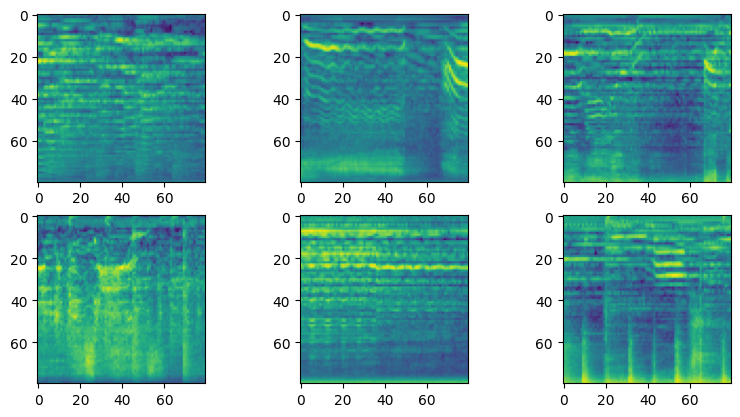

In [14]:
# inspect the first few images
plot_spectrograms(2, 3, x_train, np.arange(0, 6))

# P1

In [15]:
# Model definition and compilation.
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

loss_f = tf.keras.losses.CategoricalCrossentropy()

model = Sequential()
# CNN block
model.add(Conv2D(filters=4,
                 kernel_size=(5, 5),
                 padding="same",
                 activation="relu",
                 input_shape=(80, 80, 1))
)
model.add(MaxPooling2D(pool_size=2, strides=2))

# CNN block
model.add(Conv2D(filters=8,
                 kernel_size=(5, 5),
                 padding="same",
                 activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# CNN block -> Dense -> Output
model.add(Conv2D(filters=16,
                 kernel_size=(5, 5),
                 padding="same",
                 activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(4, activation='softmax'))

# model summary
model.summary()

# compile the model with a cross-entropy loss and specify the given optimizer
# using CategoricalCrossentropy class with one-hot encoded labels
model.compile(optimizer='sgd', loss=loss_f, metrics=['accuracy'])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 4)         104       
                                                                 
 max_pooling2d (MaxPooling2  (None, 40, 40, 4)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 8)         808       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 16)        3216      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 16)        0

In [16]:
# Model fit. Remember to use the CPU runtime and set the seed before:

history = model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(x_val, y_val)
)

Epoch 1/20
124/124 [==============================] - 53s 383ms/step - loss: 2.0292 - accuracy: 0.4971 - val_loss: 2.0783 - val_accuracy: 0.4925
Epoch 2/20
124/124 [==============================] - 20s 159ms/step - loss: 1.6543 - accuracy: 0.6908 - val_loss: 1.6249 - val_accuracy: 0.6858
Epoch 3/20
124/124 [==============================] - 21s 173ms/step - loss: 1.5079 - accuracy: 0.7300 - val_loss: 1.4574 - val_accuracy: 0.7296
Epoch 4/20
124/124 [==============================] - 20s 159ms/step - loss: 1.4307 - accuracy: 0.7487 - val_loss: 1.3984 - val_accuracy: 0.7560
Epoch 5/20
124/124 [==============================] - 23s 189ms/step - loss: 1.3398 - accuracy: 0.7749 - val_loss: 1.3236 - val_accuracy: 0.7756
Epoch 6/20
124/124 [==============================] - 20s 160ms/step - loss: 1.2574 - accuracy: 0.7921 - val_loss: 1.2940 - val_accuracy: 0.7699
Epoch 7/20
124/124 [==============================] - 22s 174ms/step - loss: 1.2096 - accuracy: 0.7969 - val_loss: 1.1932 - val_ac

### rest of P1..

## 1. Will it overfit?
There are 84382 parameters in this model. For several reasons I don't expect overfitting.

- We use considerably harsh regularization of the the last hidden dense layer, which is the most parameter-heavy. We use a 100x higher l2-regularization coefficient than the default value.

- Max-Pooling layers are included in the CNN-blocks of the architecture, which reduce the number of trainable parameters.

- Given the number of parameters, and the complexity of the dataset, I don't expect 20 epochs is enough training for this model to overfit.


However, not knowing how quickly the weights will converge during training, I wouldn't rule out the possibility of overfitting. Observing the loss-curves during training gives a better idea of how complex the data are relative to the model's capacity and learning efficiency.

## 2. Training and validation performance

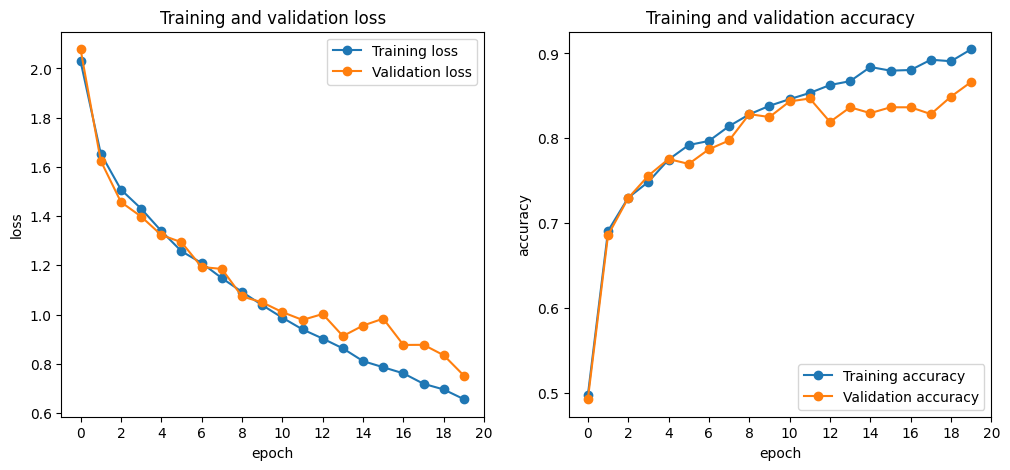

In [17]:
# From these graphs, it looks as though we could train the model for more epochs and
# improved on this performance (validation loss hasn't reached its potential minimum)


xticks = np.arange(0, 21, 2)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(history.history['loss'],'-o', label='Training loss')
ax1.plot(history.history['val_loss'],'-o', label='Validation loss')
ax1.set(title='Training and validation loss',
        ylabel='loss',
        xlabel='epoch',
        xticks=xticks)
ax1.legend(loc='upper right')

ax2.plot(history.history['accuracy'],'-o', label='Training accuracy')
ax2.plot(history.history['val_accuracy'],'-o', label='Validation accuracy')
ax2.set(title='Training and validation accuracy',
        ylabel='accuracy',
        xlabel='epoch',
        xticks=xticks)
ax2.legend(loc='lower right')
ax2.set_xticks(xticks)

plt.show()

## 3. Test set accuracy

In [18]:
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy %.2f%%' % accuracy)

Test accuracy 87.37%


## 4. Confusion matrices
**Train:** These results show the model identifies Classical music with the highest accuracy in comparison to the other genres. The least accuracy was achieved for the Rock music genre. Understandably, Metal and Rock songs were misclassified as each other quite often, but the most common misclassification was Rock being predicted to as Disco. The opposite misclassification was also fairly common.

<br>

**Test:** Results were similar to the training set, but the least accuracy was achieved for the Disco genre rather than Rock. Note that these were the bottom 2 in terms of accuracy in the training set.

In [19]:
# store model predictions in a vector for confusion matrix
pred_train = model.predict(x_train)
pred_train = np.argmax(pred_train, axis=1)

pred_test = model.predict(x_test)
pred_test = np.argmax(pred_test, axis=1)

print(pred_train.shape, pred_test.shape)

37/37 [==============================] - 2s 49ms/step
(3959,) (1172,)


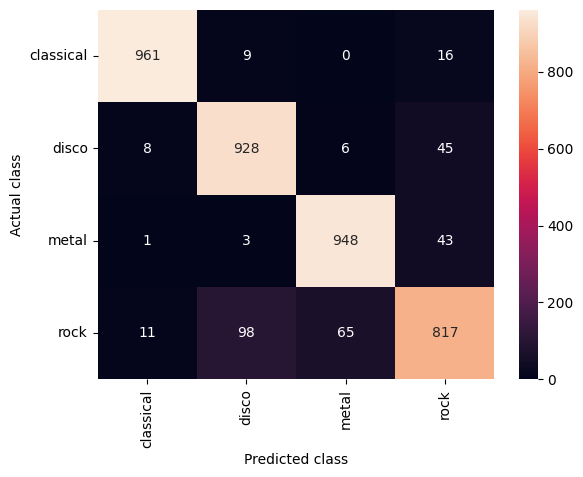

In [20]:
# 4. confusion matrices for train and test performance eval
# train
labels = ['classical', 'disco', 'metal', 'rock']
plot_confusion_matrix(y_train_num, pred_train, labels)


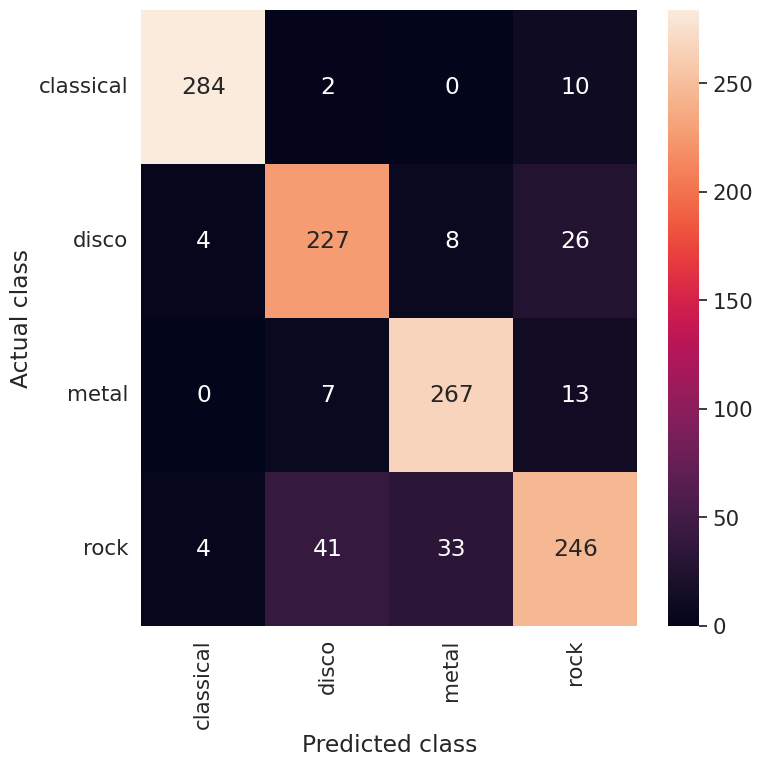

In [21]:
#test
plot_confusion_matrix(y_test_num, pred_test, labels)

## 5. Spectrograms, Incorrect Predictions, Grad-CAM

#### Mel-Spectrograms
We can observe vague differences between the mel-frequency profiles of the different genres. For example, Comparing classical and metal, we see that higher frequencies are used more in classical music, and the frequency usage is more consistent (longer horizontal streaks).

In contrast, metal seems to use more of the lower frequencies, and the usage of frequencies is more fragmented over time (shorter horizontal streaks, frequency profiles are more "noisy").

<br>

#### Grad-CAM Spectrograms
I will refer to each bin of the Grad-CAM heatmap as a pixel. Note that since my observations are made on few samples, I recognise that they are loose.

<br>

The Grad-CAM heatmaps suggest that different regions of the image (after transformations)
are used for the correct classification of each music genre, and the usage profiles also differ.
; For example, the neighboring pixels tend to share similar gradients in the classical sample. In contrast,
the gradients in the rock sample are generally more sparse.

In the incorrect classification cases, the Grad-CAM heatmaps tend to be more sparse than in the correct casea.
We may be able to associate the increased sparsity in the gradients with model uncertainty. In several of the
incorrect cases, the heatmap is almost blank, in fact.




In [22]:
# 5. Setup
classical_corr, classical_incorr = ind_correct_uncorrect(model, x_train, 0)
disco_corr, disco_incorr = ind_correct_uncorrect(model, x_train, 1)
metal_corr, metal_incorr = ind_correct_uncorrect(model, x_train, 2)
rock_corr, rock_incorr = ind_correct_uncorrect(model, x_train, 3)

#assert(len(rock_corr) == 817)

corr_incorr = {"classical": (classical_corr, classical_incorr),
               "disco": (disco_corr, disco_incorr),
               "metal": (metal_corr, metal_incorr),
               "rock": (rock_corr, rock_incorr)}

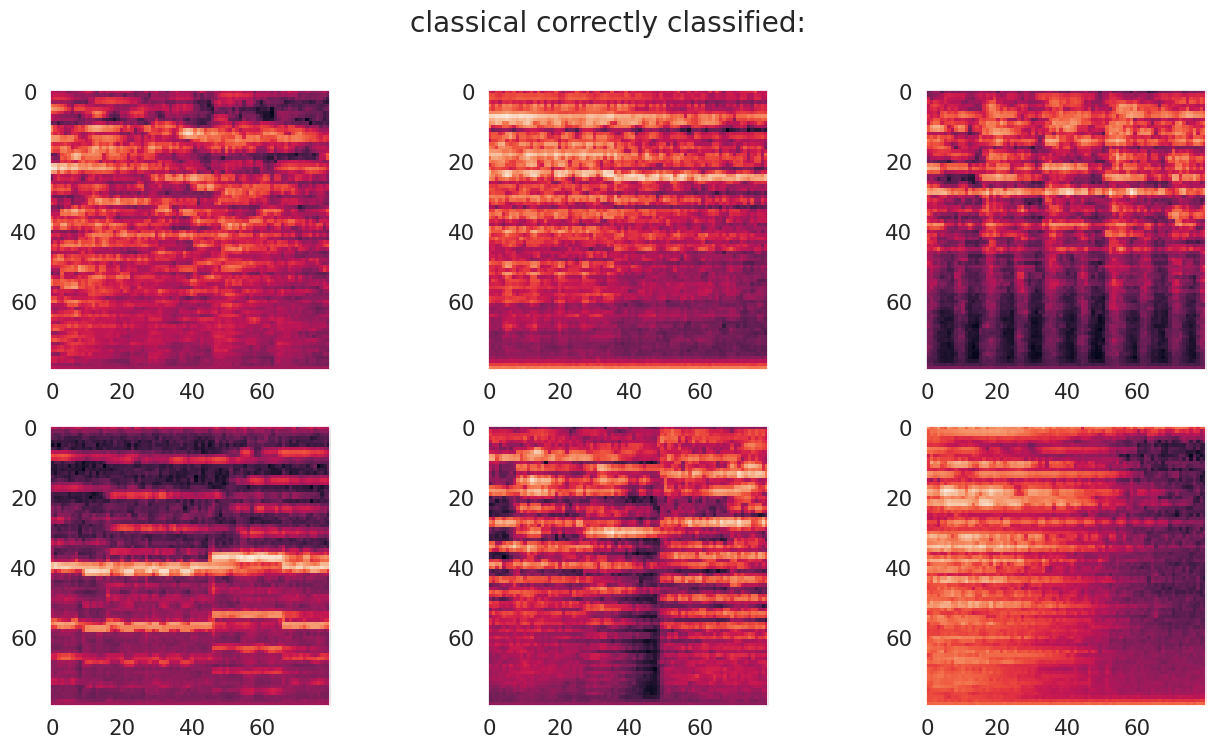

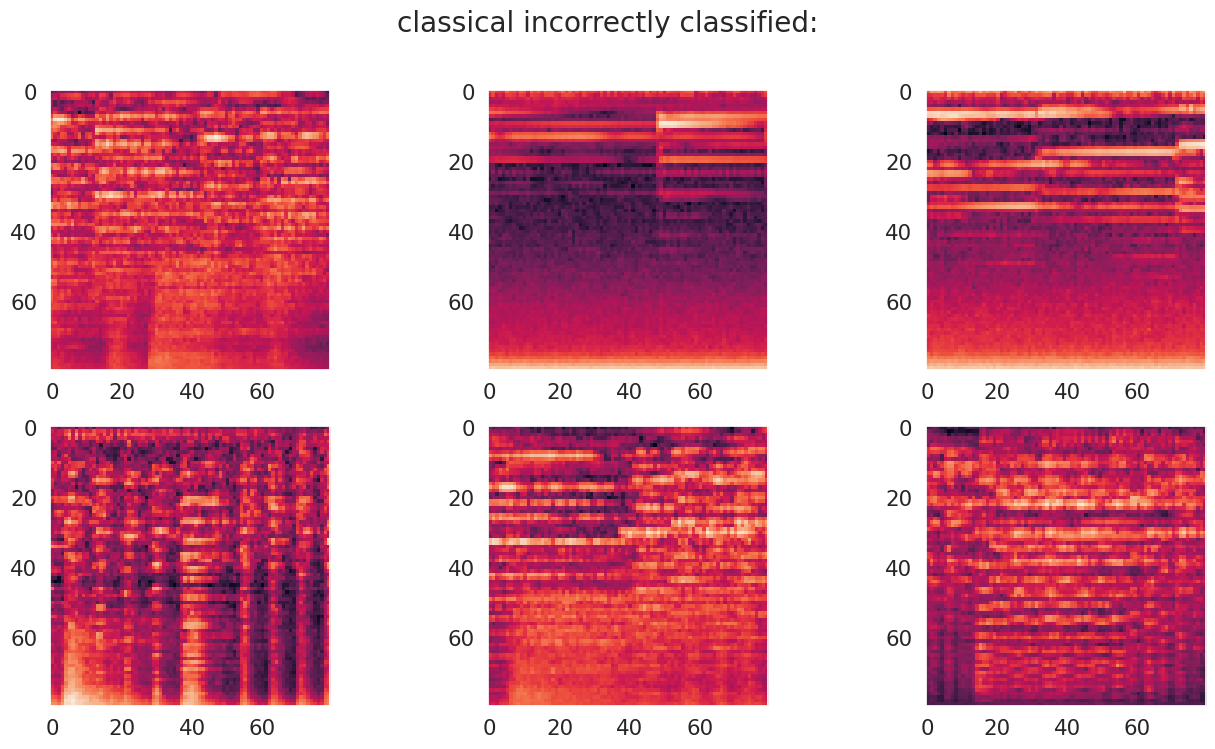

Wrongly predicted points for true class classical
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is disco
predicted class is rock
predicted class is disco



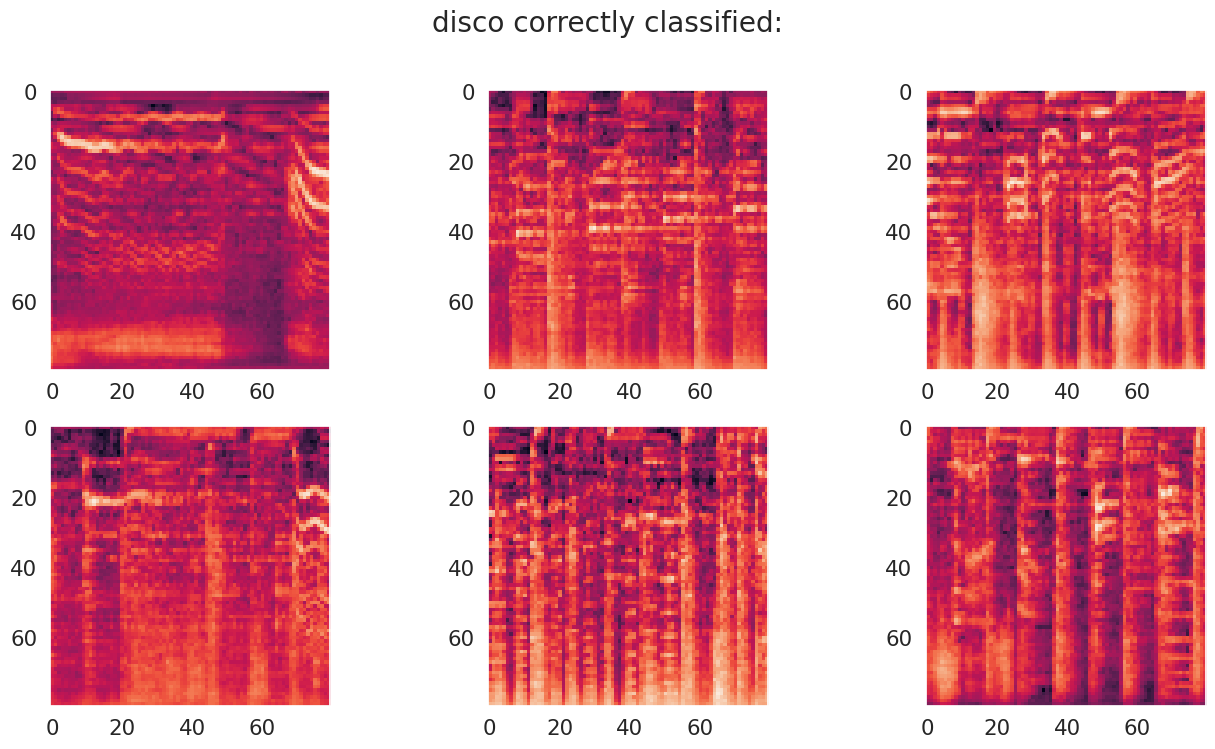

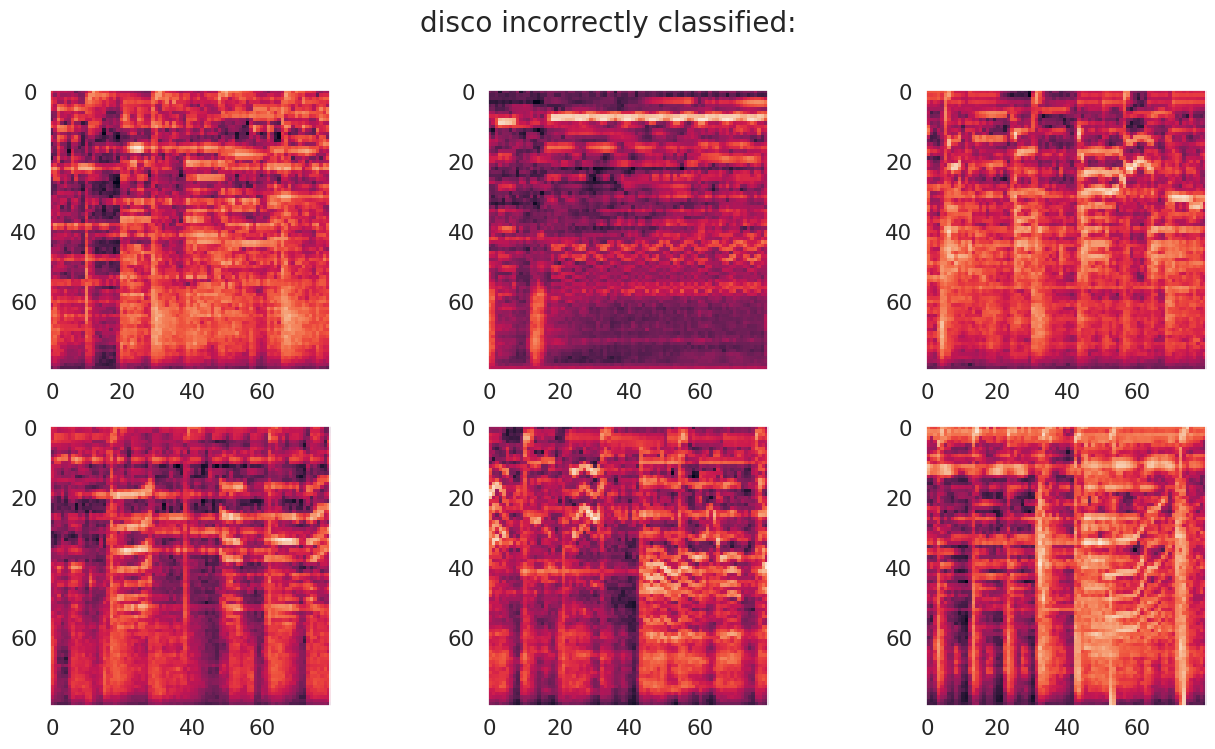

Wrongly predicted points for true class disco
predicted class is rock
predicted class is rock
predicted class is metal
predicted class is rock
predicted class is rock
predicted class is rock



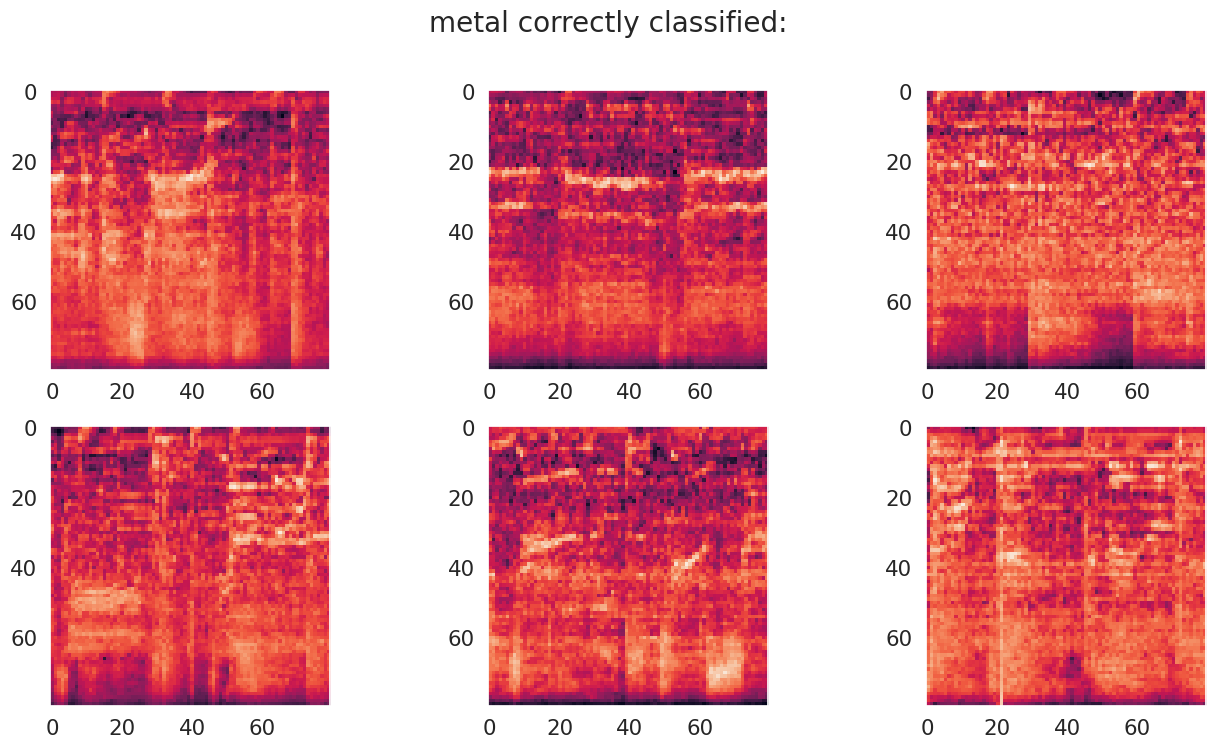

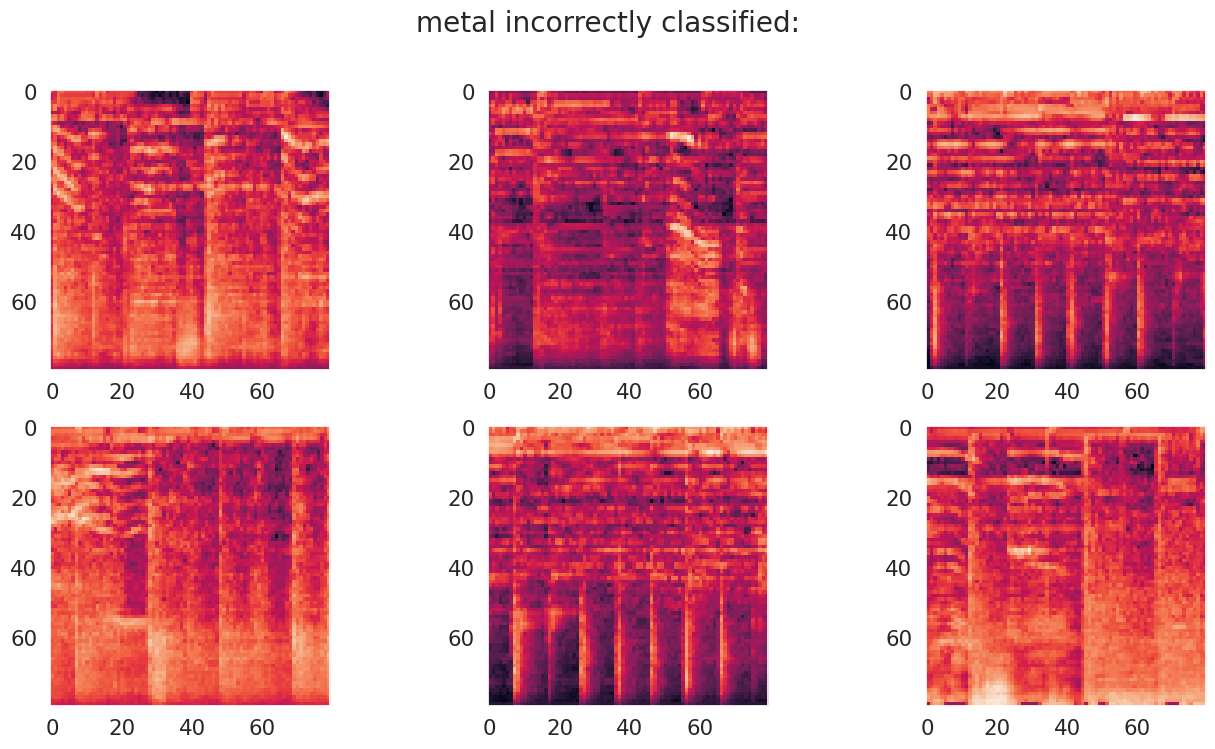

Wrongly predicted points for true class metal
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock



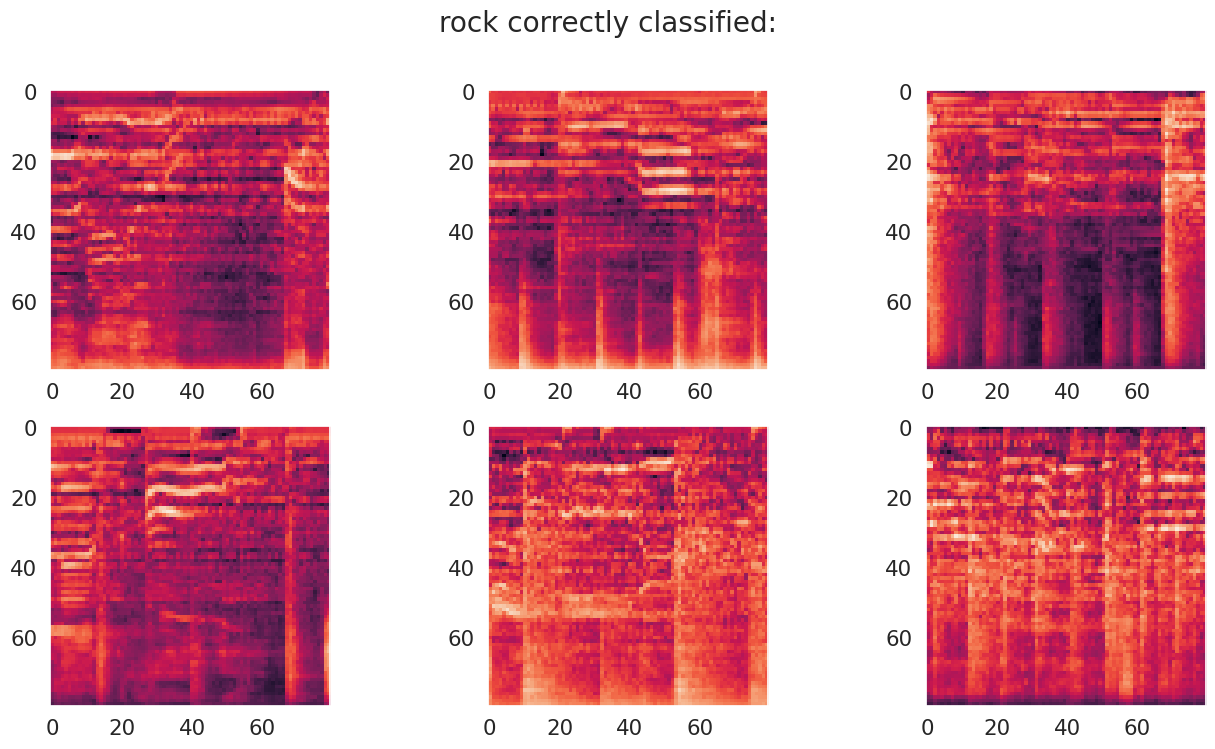

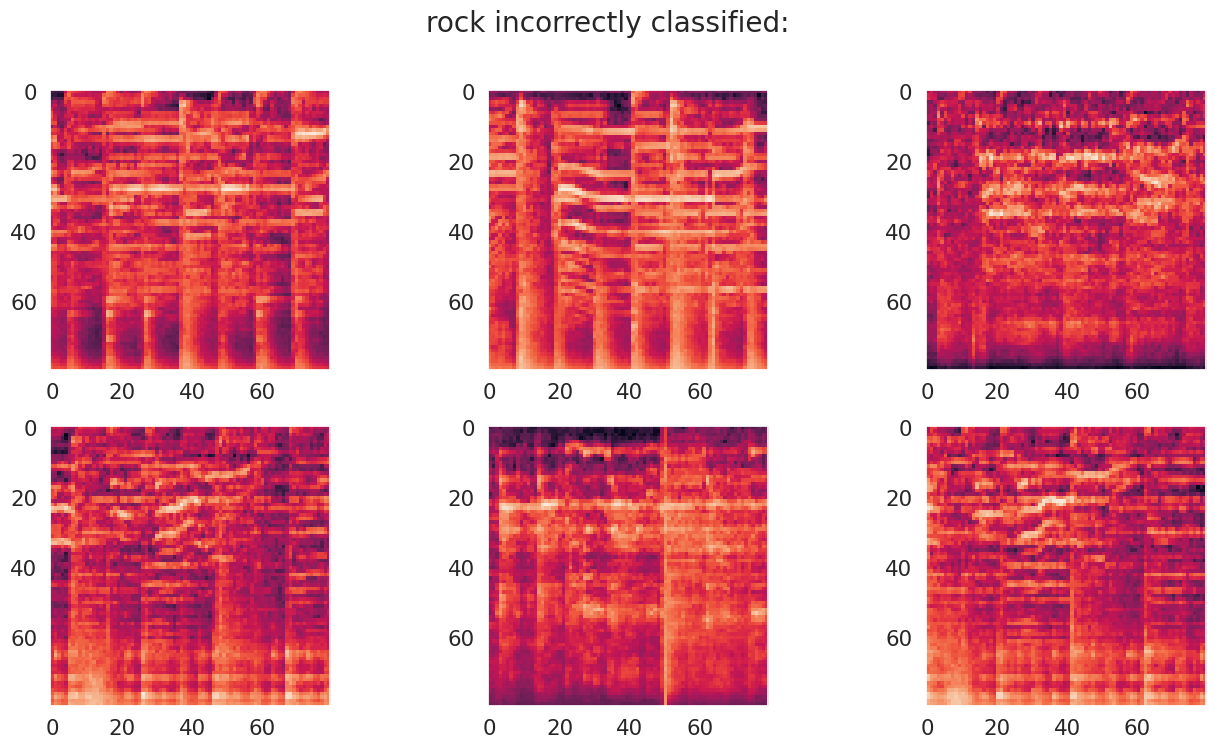

Wrongly predicted points for true class rock
predicted class is disco
predicted class is disco
predicted class is metal
predicted class is disco
predicted class is disco
predicted class is disco



In [23]:

# 5. Spectrograms + print_wrong_prediction for each class
for i, entry in enumerate(corr_incorr.items()):
  genre, t = entry[0], entry[1]

  plot = plot_spectrograms(2, 3, x_train, t[0][:6])
  plt.suptitle(f"{genre} correctly classified:")
  plt.show()
  print()

  plot = plot_spectrograms(2, 3, x_train, t[1][:6])
  plt.suptitle(f"{genre} incorrectly classified:")
  plt.show()
  f6_incorrect = t[1][:6]
  print_wrong_prediction(model, x_train, y_train, f6_incorrect, i, labels)
  print()


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 4)         104       
                                                                 
 max_pooling2d (MaxPooling2  (None, 40, 40, 4)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 8)         808       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 16)        3216      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 16)        0

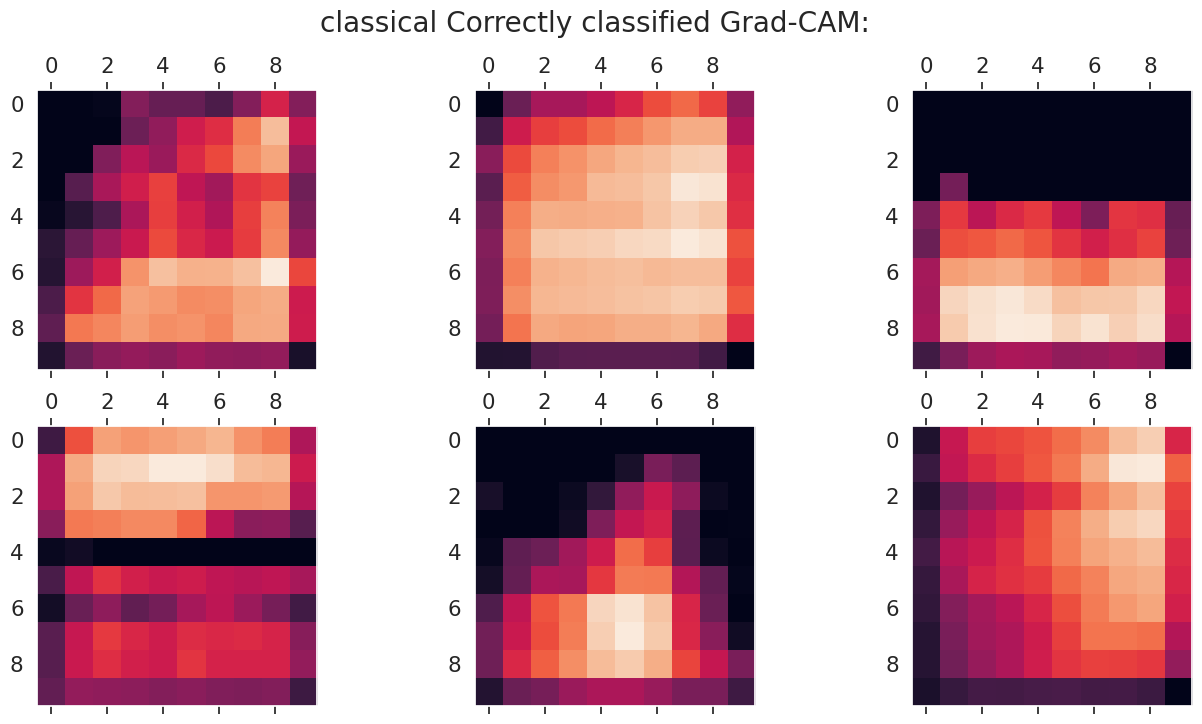

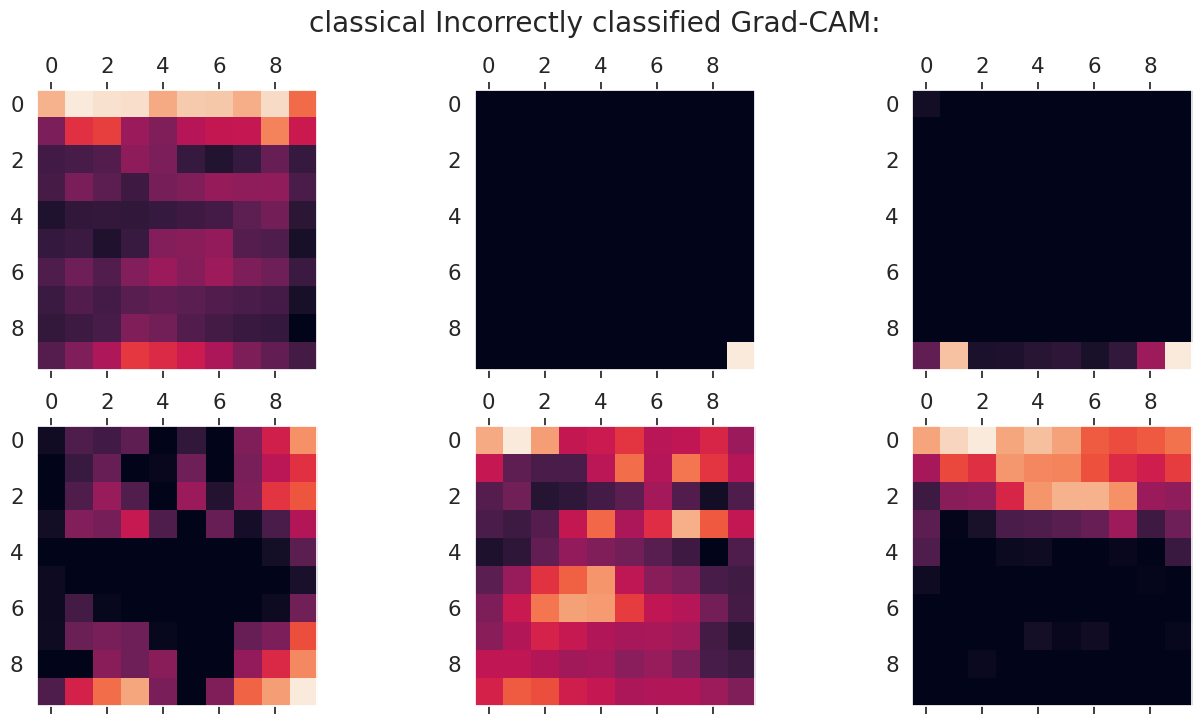

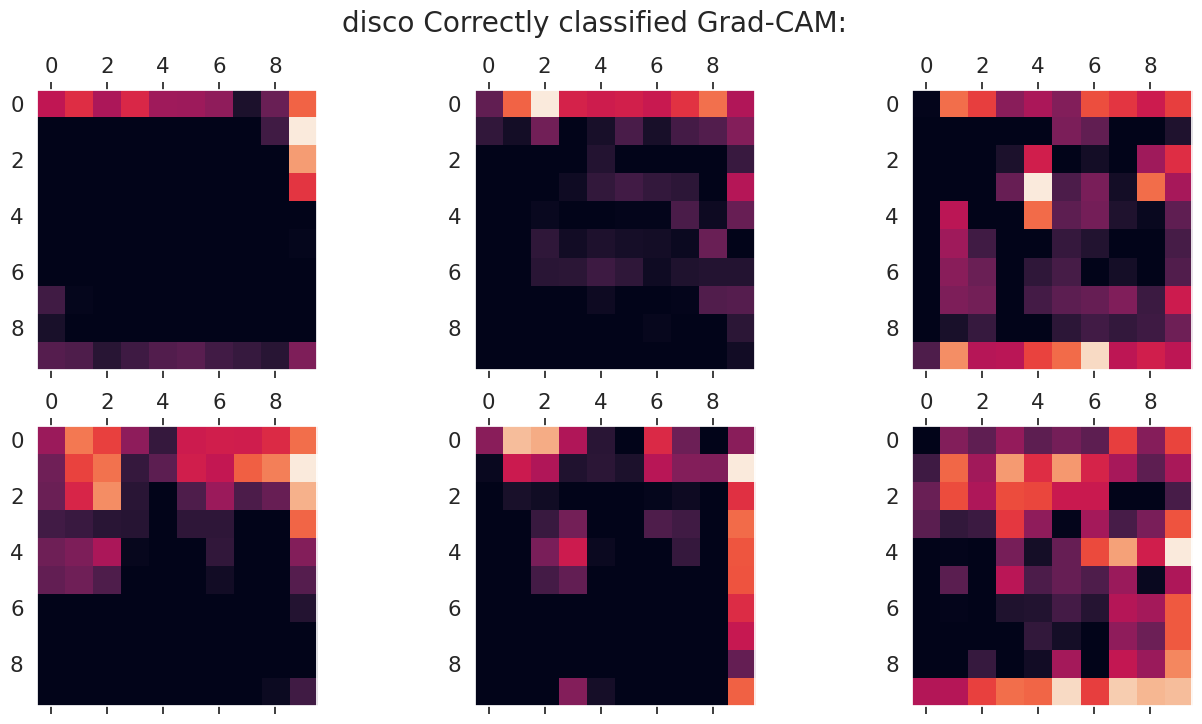

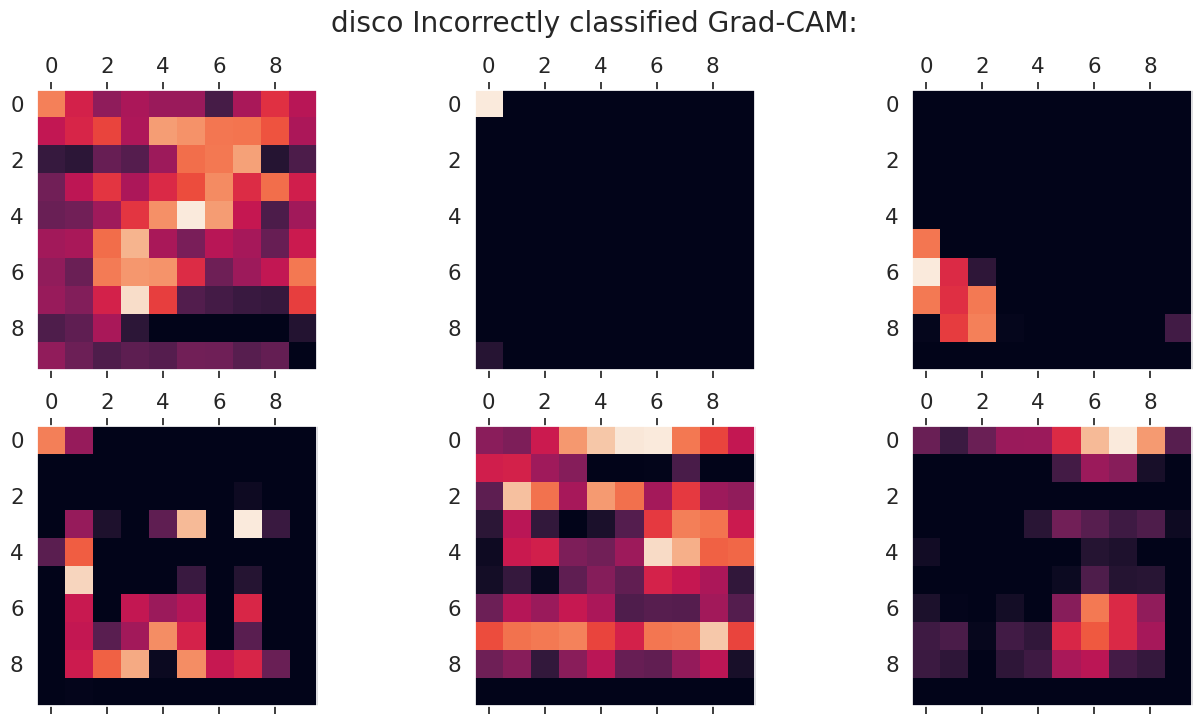

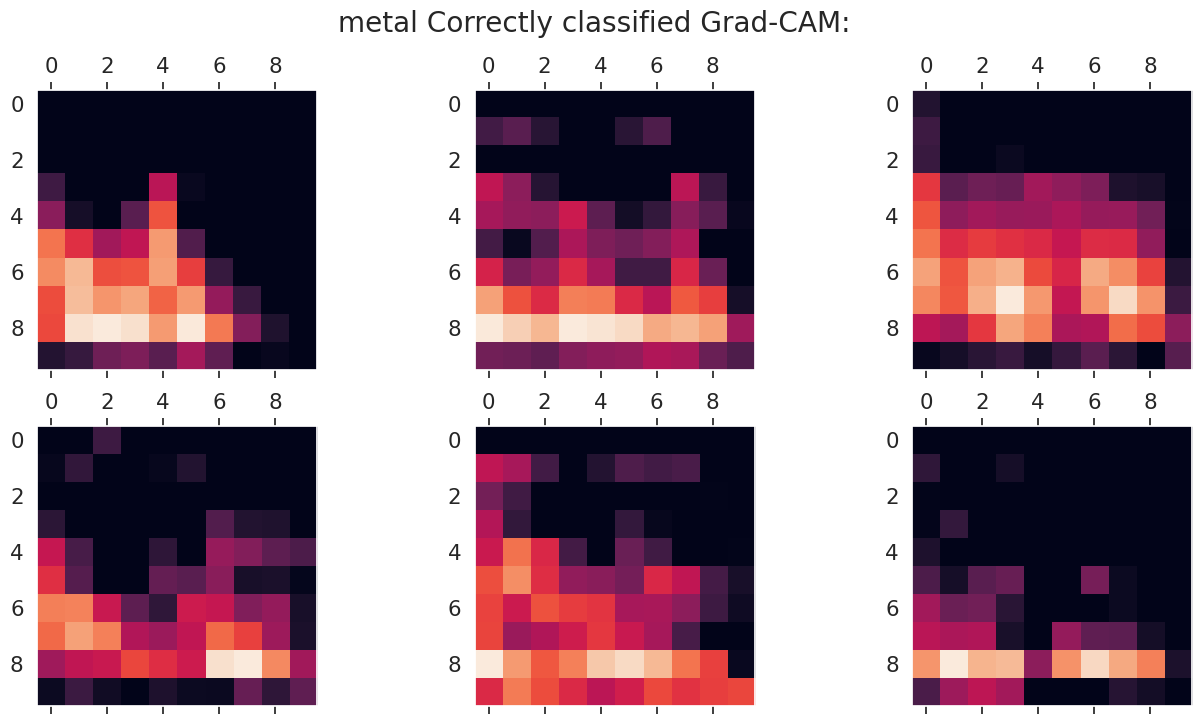

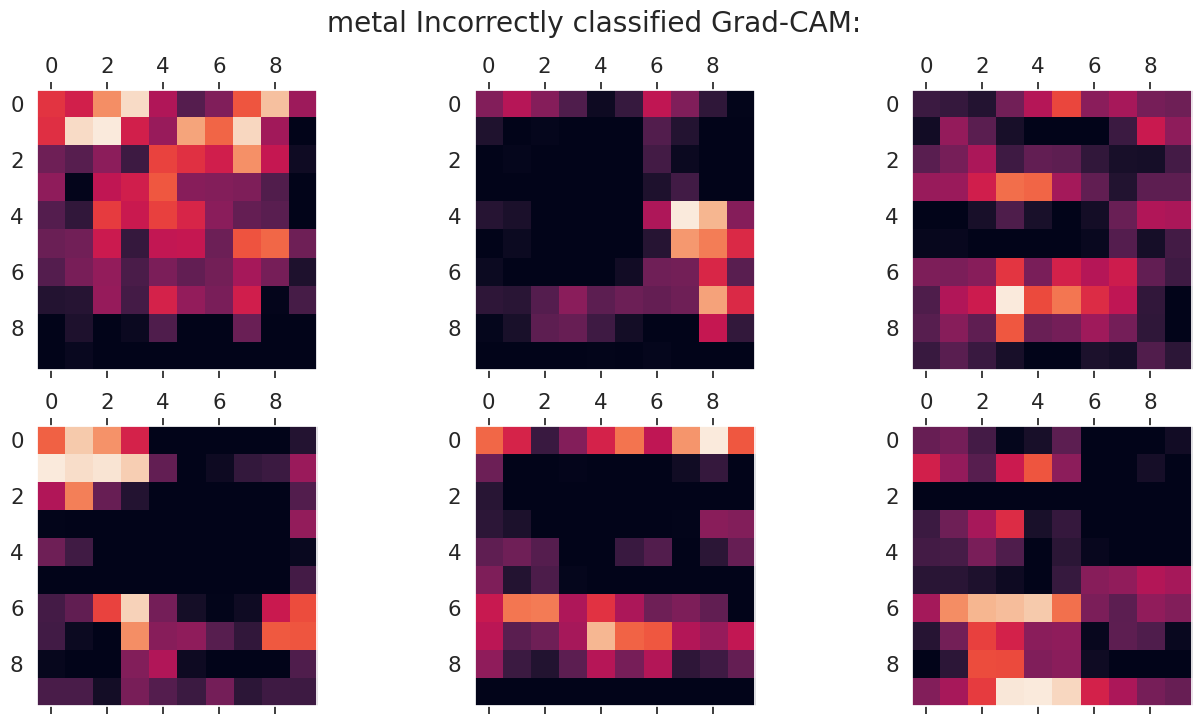

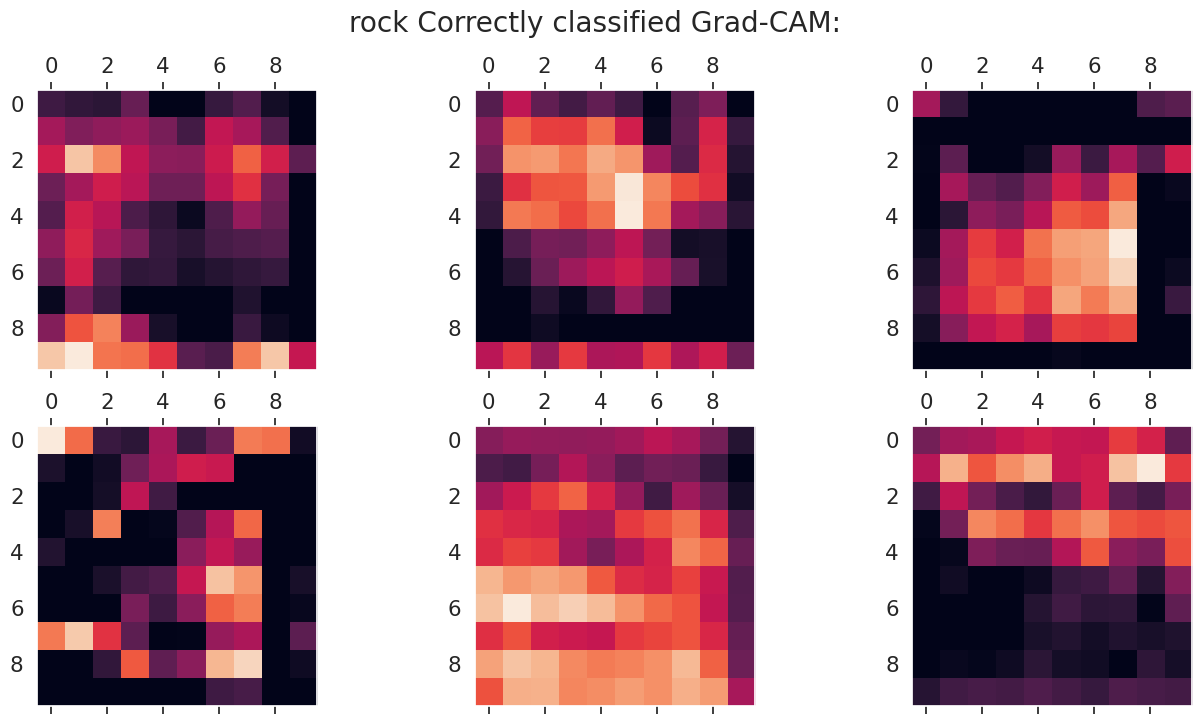

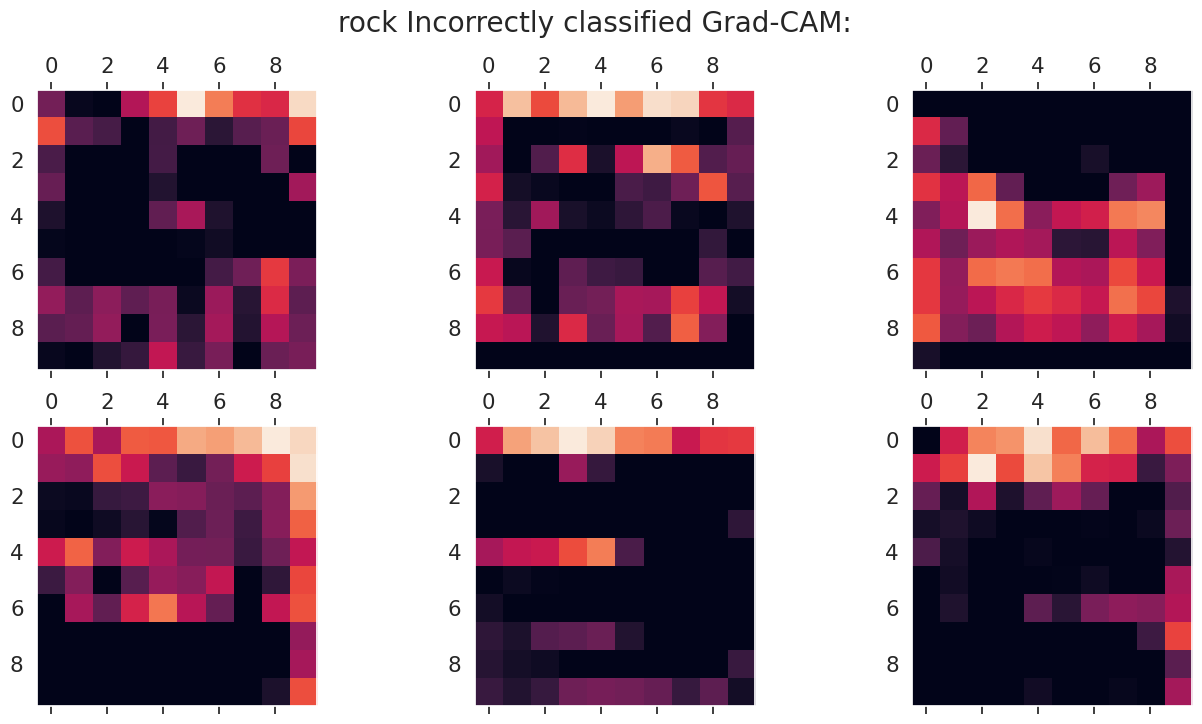

In [25]:
# 5. Grad-CAM Spectroggrams
layer_name = 'max_pooling2d_2'

for i, entry in enumerate(corr_incorr.items()):
  genre, t = entry[0], entry[1]
  plot = plot_gradcam_spectrogram(2, 3, x_train, t[0][:6], model, layer_name)
  plt.suptitle(f"{genre} Correctly classified Grad-CAM:")
  plt.show()
  print()

  plot = plot_gradcam_spectrogram(2, 3, x_train, t[1][:6], model, layer_name)
  plt.suptitle(f"{genre} Incorrectly classified Grad-CAM:")
  plt.show()
  f6_incorrect = t[1][:6]
  print()


## 6. Applicability of Grad-CAM on Mel-Frequency data

I think that in this context, the Grad-CAM tool is applicable, but may not be as helpful as in other image-classification settings because the data representation used for modelling isn't ideal for human inspection. When we want to know the genre of a song, we don't tend to look at the Mel-frequency cepstrum coefficients of the audio signal; we just listen to the s////ong.

Whereas in the context of, say, classifying images of car models, we will look at the images to identify the car, and so will the CNN. So I believe the Grad-CAM spectrogram is more useful in that case, since we can associate regions of high gradient with parts of the image in a way that is more interpretable.

That being said, the Grad-CAM is still useful, and it could allow us to find characteristic differences between the frequency profiles of different genres which are picked up by the model.

# P2

## **Proposed architecture**
To enable the neural net to separately account for time and frequency in predictions, I propose the following architecture. This is an adaptation of our previous architecture, but with additional paths for learning the time and frequency components separately.

ReLU activation functions for each trainable layer unless otherwise specified. Each path is flattened prior to concatenation for dimension compatibility.

<br>

### Path 1 (Main block):
Same as model in P1, increasing the number of filters in each convolution layer. All kernels in this path are 5x5. The idea of keeping this part in the archtecture is that considering both dimensions (time and frequency) at the same time is helpful for predicting the music-genre. For example, to utilise  $f_{a, t}$ (frequency $a$ at time $t$), knowing the amplitudes of neighboring frequencies at close time points {$f_{a-1,t}$, $f_{a+1,t}$ $f_{a,t-1}$, $f_{a,t+1}$} provides useful context.

As an analogy, when we listen to a song, we don't consider each chord in a memoryless manner. Each chord is relevant to the next, and each note is
relevant to identifying the chord.

**Structure**:  
Conv2D(4 filters) -> MaxPooling2D ->  
Conv2D(8 filters) -> MaxPooling2D ->  
Conv2D(16 filters) -> MaxPooling2D  ->
Flatten()

<br>

### Path 2 (Frequency summary)
Here, we include horizontal convolutions with the aim of summarise each frequency level of the audio. The result is filters of shape (1, 80), which on a forward pass, summarise each frequency level. For a single frequency $a$ and a single filter, the following is computed:

$$h(\mathbf{a}) = \sigma(w_1 · a_1 + w_2 · a_2 +  \dots + w_{80} \cdotp a_{80})$$

where $\mathbf{a} = (a_1, a_2, ..., a_80)$ is a vector of amplitudes for frequency $a$ at time points 1 to 80 and σ is an activation function.

**Structure**:  
Conv2D(4 filters, kernel_size=(1, 80)) ->
Flatten()

<br>


### Path 3 (Time summary)
Here we use vertical convolutions to try and summarise each time point of the audio. The resulting filters are of shape (80, 1). On a forward pass, they summarise the frequency profile at each time point. The computations are similar to path 2.

**Structure**:  
Conv2D(4 filters, kernel_size=(1, 80)) ->
Flatten()

<br>

### Combining paths
The outputs of the 3 paths are combined by concatenation, resulting in a 2240-scalar vector. The vector passes through a fully connected layer, before reaching the output layer of class-probabilities. The softmax activation function is used for this multiclass classification task.

<br>

## **Results**
In 20 training epochs, this model outperforms the P1 model on both the training and test sets, achieving an accuracy of **92.49%** on the test set in comparison to the P1 model's **87.37%**.

In [26]:
# Model definition and compilation.
tf.keras.utils.set_random_seed(42)

loss_f = tf.keras.losses.CategoricalCrossentropy()
input_layer = tf.keras.Input(shape=(80, 80, 1))

class TF_net(tf.keras.Model):
  def __init__(self, c2=4, c3=4):
    # path 1: main conv
    super().__init__()
    self.p1_conv1 = Conv2D(filters=4,
                 kernel_size=(5, 5),
                 padding="same",
                 activation="relu",
                 input_shape=(80, 80, 1))
    self.p1_mp1 = MaxPooling2D(pool_size=2, strides=2)

    self.p1_conv2 = Conv2D(filters=8,
                 kernel_size=(5, 5),
                 padding="same",
                 activation="relu",
                 input_shape=(80, 80, 1))
    self.p1_mp2 = MaxPooling2D(pool_size=2, strides=2)

    self.p1_conv3 = Conv2D(filters=16,
                 kernel_size=(5, 5),
                 padding="same",
                 activation="relu",
                 input_shape=(80, 80, 1))
    self.p1_mp3 = MaxPooling2D(pool_size=2, strides=2)

    # path 2: frequency
    # c2 is the number of channels used for the frequency convolution layer
    self.p2_conv = Conv2D(filters=c2,
                                kernel_size=(1, 80),
                                activation="relu")


    # path 3: time
    # c3 is the number of channels used for the time convolution layer
    self.p3_conv = Conv2D(filters=c3,
                            kernel_size=(80, 1),
                            activation="relu")

    self.flatten = Flatten()

  def call(self, x):
    # build first path
    p1 = self.p1_conv1(x)
    p1 = self.p1_mp1(p1)
    p1 = self.p1_conv2(p1)
    p1 = self.p1_mp2(p1)
    p1 = self.p1_conv3(p1)
    p1 = self.p1_mp3(p1)
    p1 = self.flatten(p1)
    print(p1.shape)

    p2 = self.p2_conv(x)
    p2 = self.flatten(p2)
    print(p2.shape)

    p3 = self.p3_conv(x)
    p3 = self.flatten(p3)
    print(p3.shape)

    # concatenate outputs
    concat = Concatenate()([p1, p2, p3])

    return concat



In [27]:
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

tfn = TF_net(c2=4, c3=4).call(input_layer)
x = Dense(50, activation="relu", kernel_regularizer=l2(0.01))(tfn)
out = Dense(4, activation='softmax')(x)

# final model
my_model = tf.keras.Model(input_layer, out)

# model compilation
my_model.compile(optimizer = 'adam', loss = loss_f, metrics = ['acc'])
my_model.summary()

(None, 1600)
(None, 320)
(None, 320)
Model: "model_48"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80, 80, 1)]          0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 80, 80, 4)            104       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 40, 40, 4)            0         ['conv2d_3[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 40, 40, 8)        

In [28]:
# Model fit. Remember to use the CPU runtime and set the seed before:
my_model_history =  my_model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(x_val, y_val)
)

Epoch 1/20
124/124 [==============================] - 27s 199ms/step - loss: 1.0139 - acc: 0.7290 - val_loss: 0.7170 - val_acc: 0.7929
Epoch 2/20
124/124 [==============================] - 21s 166ms/step - loss: 0.5800 - acc: 0.8338 - val_loss: 0.5391 - val_acc: 0.8573
Epoch 3/20
124/124 [==============================] - 23s 189ms/step - loss: 0.4820 - acc: 0.8596 - val_loss: 0.6229 - val_acc: 0.7791
Epoch 4/20
124/124 [==============================] - 26s 207ms/step - loss: 0.3951 - acc: 0.8901 - val_loss: 0.4368 - val_acc: 0.8792
Epoch 5/20
124/124 [==============================] - 22s 175ms/step - loss: 0.3643 - acc: 0.8985 - val_loss: 0.5207 - val_acc: 0.8446
Epoch 6/20
124/124 [==============================] - 23s 186ms/step - loss: 0.3359 - acc: 0.9116 - val_loss: 0.3776 - val_acc: 0.8976
Epoch 7/20
124/124 [==============================] - 22s 177ms/step - loss: 0.2994 - acc: 0.9214 - val_loss: 0.3814 - val_acc: 0.8930
Epoch 8/20
124/124 [==============================] - 2

## Training and validation performance

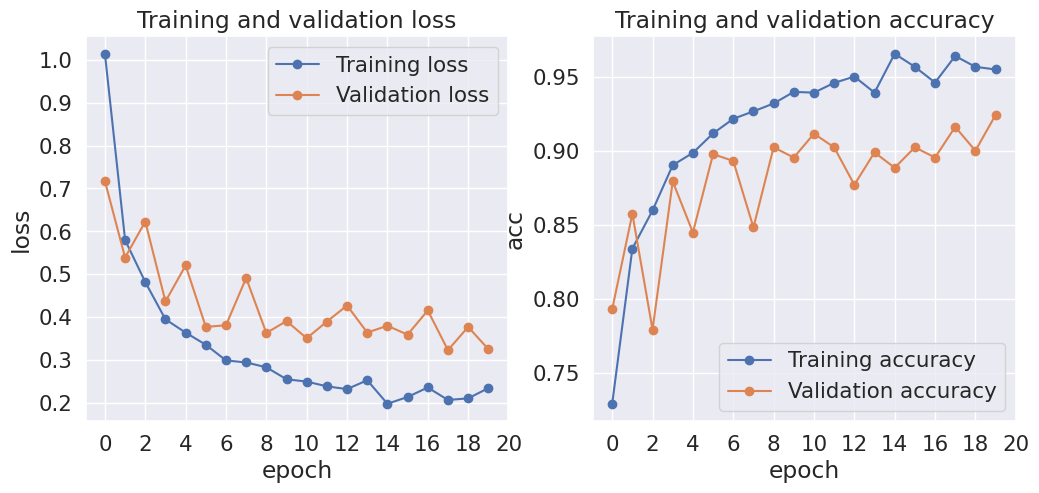

In [29]:
xticks = np.arange(0, 21, 2)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(my_model_history.history['loss'],'-o', label='Training loss')
ax1.plot(my_model_history.history['val_loss'],'-o', label='Validation loss')
ax1.set(title='Training and validation loss',
        ylabel='loss',
        xlabel='epoch',
        xticks=xticks)
ax1.legend(loc='upper right')

ax2.plot(my_model_history.history['acc'],'-o', label='Training accuracy')
ax2.plot(my_model_history.history['val_acc'],'-o', label='Validation accuracy')
ax2.set(title='Training and validation accuracy',
        ylabel='acc',
        xlabel='epoch',
        xticks=xticks)
ax2.legend(loc='lower right')
ax2.set_xticks(xticks)

plt.show()

## Test set accuracy

In [30]:
score = my_model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy %.2f%%' % accuracy)

Test accuracy 92.49%


## Confusion matrices

In [31]:
# store model predictions in a vector for confusion matrix
pred_train = my_model.predict(x_train)
pred_train = np.argmax(pred_train, axis=1)

pred_test = my_model.predict(x_test)
pred_test = np.argmax(pred_test, axis=1)

print(pred_train.shape, pred_test.shape)

37/37 [==============================] - 2s 49ms/step
(3959,) (1172,)


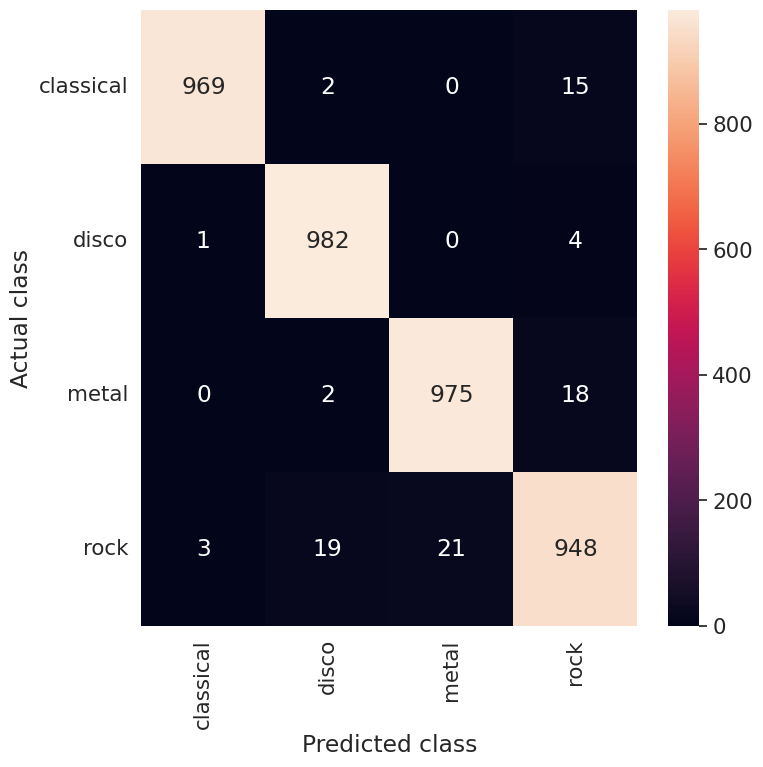

In [32]:
# 4. confusion matrices for train and test performance eval
# train
labels = ['classical', 'disco', 'metal', 'rock']
plot_confusion_matrix(y_train_num, pred_train, labels)


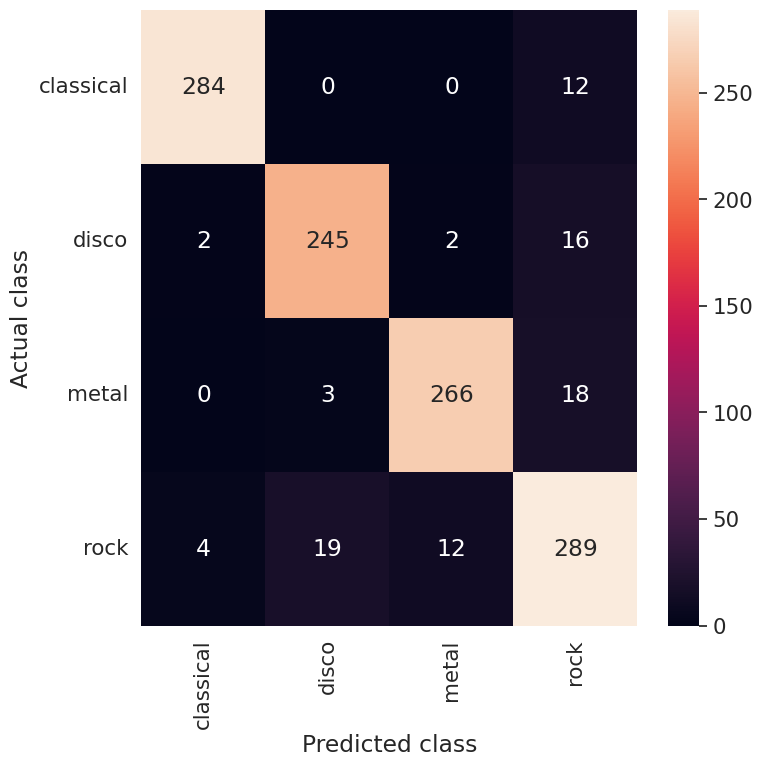

In [33]:
#test
plot_confusion_matrix(y_test_num, pred_test, labels)